### Step 4: After obtaining sentiment analysis results, we need to compare them and get deliverables for the report.

In [1]:
import boto3
import pandas as pd
import json
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
AWS_REGION = 'eu-west-1' 
S3_BUCKET_NAME = 'aruzhan-sabira-hw3' 

# The folder where the JSON result files were saved
S3_RESULTS_PREFIX = 'sentiment_results_sync/' 

s3_client = boto3.client('s3', region_name=AWS_REGION)

In [3]:
COUNTRY_MAPPING = {
    'ai-bubble-us-economy': 'The Guardian (USA)',
    'are-we-in-an-ai-bubble-we-asked-european-investors': 'Poland (Vestbee)',
    'japan-media-ai-threat': 'Japan (Japan Times)',
    'kazakhstan-advances-ai-digital-ecosystem-developme': 'Kazakhstan (Astana Times)',
    'uzbekistan-to-lay-off-over-2000-government-employe': 'Uzbekistan (Qaz Inform)',
    'eksperty-vse-chasche-nazyvayut-bum-iskusstvennogo-': 'Russia (Meduza)',
    'c11d1f63-a085-419d-bc62-030911459304': 'Australia (9 News)', 
    '124362358.cms': 'India (The Times of India)', 
    'blasen-bei-ki-werten-platzen-sie-bald-oder-geht-da': 'Germany (Handelsblatt)', 
    'resultados-da-oracle-sinalizam-bolha-de-ia-entenda': 'Brazil (CNN Brazil)',
    'une-bulle-de-l-intelligence-artificielle': 'France (La Gazette)',
    '1206507': 'Thailand (Bangkok BizNews)',
}

In [4]:
def aggregate_sentiment_data(bucket_name, prefix, s3_client):
    """
    Lists all JSON files in the S3 results folder, downloads them, 
    flattens the data, and returns a single Pandas DataFrame.
    """
    all_data = []
    
    # 1. List objects in the output prefix
    paginator = s3_client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
    
    print(f"Listing result files in s3://{bucket_name}/{prefix}...")

    for page in pages:
        if 'Contents' not in page:
            continue
            
        for obj in page['Contents']:
            input_key = obj['Key']
            
            # Only process the JSON result files
            if not input_key.endswith('.json'):
                continue

            try:
                # 2. Download and read the file content
                response = s3_client.get_object(Bucket=bucket_name, Key=input_key)
                file_content = response['Body'].read().decode('utf-8')
                
                # 3. Load JSON data
                data = json.loads(file_content)
                
                # 4. Extract the file name (Source Media) for easy grouping
                data['MediaSource'] = os.path.basename(data['SourceFile']).replace('.json', '')
                
                all_data.append(data)
                
            except Exception as e:
                print(f"  [ERROR] Failed to process {input_key}. Error: {e}")
                continue

    if not all_data:
        print("No JSON result files were found.")
        return pd.DataFrame() # Return empty DataFrame if no data found
        
    # 5. Create DataFrame from list of dictionaries
    df = pd.DataFrame(all_data)
    
    # 6. Flatten the 'ConfidenceScores' column
    # The sentiment scores are nested, so we normalize them into separate columns.
    df_scores = pd.json_normalize(df['ConfidenceScores'])
    df_scores = df_scores.rename(columns={
        'Positive': 'Conf_Positive',
        'Negative': 'Conf_Negative',
        'Neutral': 'Conf_Neutral',
        'Mixed': 'Conf_Mixed'
    })
    
    # Combine the normalized scores with the main DataFrame
    df = pd.concat([df.drop('ConfidenceScores', axis=1), df_scores], axis=1)
    
    # Optional: Clean up and select final columns
    df = df[['MediaSource', 'Sentiment', 'Conf_Positive', 'Conf_Negative', 'Conf_Neutral', 'Conf_Mixed', 'SourceFile']]

    print(f"\n✅ Aggregation complete. Total articles processed: {len(df)}")
    return df


In [5]:
if __name__ == "__main__":
    final_df = aggregate_sentiment_data(S3_BUCKET_NAME, S3_RESULTS_PREFIX, s3_client)

    if not final_df.empty:
        final_df['MediaSource_Clean'] = final_df['MediaSource'].apply(
            lambda x: x.rsplit('_', 1)[0] if isinstance(x, str) and '_' in x else x
        )
        
        # Apply the mapping to create the Country/Region column
        final_df['Country/Region'] = final_df['MediaSource_Clean'].map(COUNTRY_MAPPING)

        final_df['Country/Region'] = final_df['Country/Region'].fillna(final_df['MediaSource_Clean'])

        comparison_table = final_df.groupby('Country/Region').agg(
            Dominant_Sentiment=('Sentiment', lambda x: x.mode()[0] if not x.mode().empty else 'N/A'),
            Positive_Score=('Conf_Positive', 'mean'),
            Negative_Score=('Conf_Negative', 'mean'),
            Neutral_Score=('Conf_Neutral', 'mean')
        ).reset_index()

        for col in ['Positive_Score', 'Negative_Score', 'Neutral_Score']:
            comparison_table[col] = comparison_table[col].map('{:.2%}'.format)

        print("\n--- Comparative Sentiment Analysis by Country/Region ---")
        print(comparison_table.to_markdown(index=False, numalign="left", stralign="left"))



Listing result files in s3://aruzhan-sabira-hw3/sentiment_results_sync/...

✅ Aggregation complete. Total articles processed: 12

--- Comparative Sentiment Analysis by Country/Region ---
| Country/Region             | Dominant_Sentiment   | Positive_Score   | Negative_Score   | Neutral_Score   |
|:---------------------------|:---------------------|:-----------------|:-----------------|:----------------|
| Australia (9 News)         | NEUTRAL              | 5.73%            | 0.31%            | 93.11%          |
| Brazil (CNN Brazil)        | NEUTRAL              | 0.40%            | 9.87%            | 89.65%          |
| France (La Gazette)        | NEUTRAL              | 9.86%            | 0.26%            | 89.47%          |
| Germany (Handelsblatt)     | NEUTRAL              | 0.23%            | 1.36%            | 97.43%          |
| India (The Times of India) | NEUTRAL              | 3.35%            | 35.67%           | 49.37%          |
| Japan (Japan Times)        | NEUTRAL     

#### A chart displaying the differences in sentiments across countries

In [6]:
LOCAL_CHART_FILENAME = 'avg_confidence_grouped_bar_chart.png'
S3_CHART_KEY = 'final_analysis_charts/' + LOCAL_CHART_FILENAME

CONFIDENCE_COLS = ['Conf_Positive', 'Conf_Negative', 'Conf_Neutral']
SCORE_MAP = {
    'Conf_Positive': 'Positive Score', 
    'Conf_Negative': 'Negative Score', 
    'Conf_Neutral': 'Neutral Score'
}
COLOR_MAP = {
    'Positive Score': '#28a745', 
    'Negative Score': '#dc3545',  
    'Neutral Score': '#ffc107'   
}


In [7]:
def generate_confidence_chart(df):
    df['MediaSource_Clean'] = df['MediaSource'].apply(
        lambda x: x.rsplit('_', 1)[0] if isinstance(x, str) and '_' in x else x
    )

    df['Country/Region'] = df['MediaSource_Clean'].map(COUNTRY_MAPPING)

    # Handle any sources not in the map (will keep their filename)
    df['Country/Region'] = df['Country/Region'].fillna(df['MediaSource_Clean'])
    
    agg_df = df.groupby('Country/Region')[CONFIDENCE_COLS].mean().reset_index()
    
    plot_df = agg_df.melt(
        id_vars='Country/Region', 
        value_vars=CONFIDENCE_COLS, 
        var_name='Confidence_Type', 
        value_name='Avg_Score'
    )

    plot_df['Confidence_Label'] = plot_df['Confidence_Type'].map(SCORE_MAP)

    # Plotting the Grouped Horizontal Bar Chart
    plt.figure(figsize=(12, max(len(agg_df) * 0.5, 6)))

    sns.barplot(
        data=plot_df,
        x='Avg_Score',
        y='Country/Region', 
        hue='Confidence_Label',
        palette=COLOR_MAP,
        errorbar=None 
    )

    plt.title('Average Sentiment Confidence Scores by Country/Media Source', fontsize=16)
    plt.xlabel('Average Confidence Score (0.0 to 1.0)', fontsize=12)
    plt.ylabel('Country/Media Source', fontsize=12)
    plt.legend(title='Confidence Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlim(0, 1.0) 
    plt.tight_layout()

    # 6. Save the plot locally
    plt.savefig(LOCAL_CHART_FILENAME)
    print(f"Chart saved locally as {LOCAL_CHART_FILENAME}")
    return LOCAL_CHART_FILENAME

In [8]:
def upload_chart_to_s3(local_path, bucket_name, s3_key, s3_client):
    """Uploads a local file to S3 using the provided client."""
    print(f"Uploading chart to s3://{bucket_name}/{s3_key}...")
    try:
        s3_client.upload_file(
            local_path, 
            bucket_name, 
            s3_key,
            ExtraArgs={'ContentType': 'image/png'} 
        )
        print("✅ SUCCESS: Chart uploaded to S3.")
    except Exception as e:
        print(f"❌ ERROR uploading chart to S3. Error: {e}")
    finally:
        if os.path.exists(local_path):
            os.remove(local_path)


Listing result files in s3://aruzhan-sabira-hw3/sentiment_results_sync/...

✅ Aggregation complete. Total articles processed: 12

--- Final Aggregated Sentiment Data with Country/Region Names ---
| Country/Region             | Sentiment   |   Conf_Positive |
|:---------------------------|:------------|----------------:|
| Thailand (Bangkok BizNews) | NEUTRAL     |      0.0337805  |
| India (The Times of India) | NEUTRAL     |      0.0335311  |
| The Guardian (USA)         | NEUTRAL     |      0.00280647 |
| Poland (Vestbee)           | NEUTRAL     |      0.130308   |
| Germany (Handelsblatt)     | NEUTRAL     |      0.00227317 |
Chart saved locally as avg_confidence_grouped_bar_chart.png
Uploading chart to s3://aruzhan-sabira-hw3/final_analysis_charts/avg_confidence_grouped_bar_chart.png...
✅ SUCCESS: Chart uploaded to S3.

Process Complete: Chart is ready in your S3 bucket.


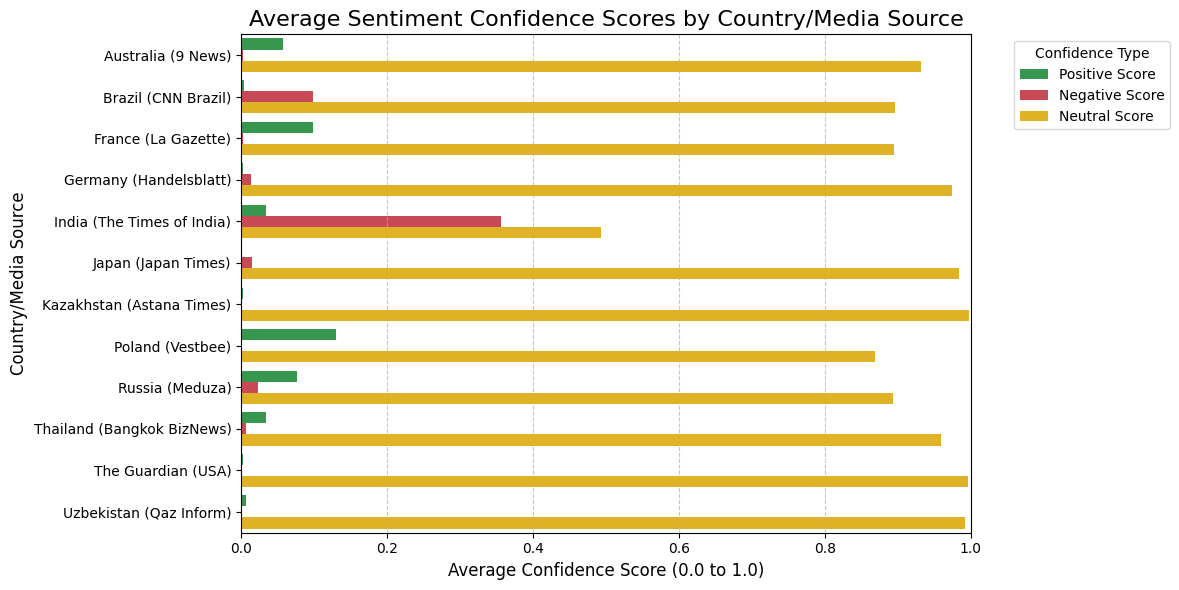

In [9]:
if __name__ == "__main__":
    final_df = aggregate_sentiment_data(S3_BUCKET_NAME, S3_RESULTS_PREFIX, s3_client)

    if not final_df.empty:
        final_df['MediaSource_Clean'] = final_df['MediaSource'].apply(
            lambda x: x.rsplit('_', 1)[0] if isinstance(x, str) and '_' in x else x
        )
        
        # Apply the mapping
        final_df['Country/Region'] = final_df['MediaSource_Clean'].map(COUNTRY_MAPPING)

        # Handle Fallback (if a key is missing, keep the cleaned filename)
        final_df['Country/Region'] = final_df['Country/Region'].fillna(final_df['MediaSource_Clean'])
        
        print("\n--- Final Aggregated Sentiment Data with Country/Region Names ---")
        print(final_df[['Country/Region', 'Sentiment', 'Conf_Positive']].head().to_markdown(index=False))

        chart_file = generate_confidence_chart(final_df)

        # Step 2: Upload chart to S3
        upload_chart_to_s3(chart_file, S3_BUCKET_NAME, S3_CHART_KEY, s3_client)

        print("\nProcess Complete: Chart is ready in your S3 bucket.")